[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Accessing, organizing, and visualizing CSV data

In the following Notebook we will briefly explore the spatially aggregated data contained in the [PECDv4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview) CSV files for one of the available energy variables (i.e. one SPV technology) and a reduced number of available datasets (the historical reconstructed series and three different climate projections).

For illustration purposes, this notebook uses a short temporal subsample of the PECDv4.2 dataset. Likewise, only a subset of the available CMIP6 climate projection models and emission scenarios is downloaded and analyzed. This approach is intended to demonstrate the workflow and methodology rather than to produce robust, policy-relevant impact assessments.
It is important to emphasize that for rigorous climate impact studies, the use of such limited data is not sufficient. Reliable analyses should be based on longer time series (typically at least 30 years) to capture interannual climate variability and trends, as well as on multiple climate models and scenarios to quantify uncertainty and assess model spread.

After downloading the data from the CDS, we will go through some simple data manipulation steps to organize the information. Then, we will visualize the data by generating two types of figures:

*   line plots: useful to visualize one or more time series (i.e. how data evolve in time) once we fix a point in space (in this case a country);

*   aggregated maps: useful to visualize the aggregated data (in this case country-level averages) on a map once we fix a point in time (or once we compute a mean over time)

All this will be coded in Python.


## Learning objectives 🎯

Throughout this notebook you will learn how to quickly download and read the PECDv4.2 CSV files and organize the contained aggregated data into a table (DataFrame). You will also learn how to select a single column of your DataFrame (a single country) or a single row (a single date), and to compute a simple mean of your data over time.
Finally you will learn how to produce a figure to show one or multiple time series, as well as a figure to visualize, on a map, the mean values for one or various countries.
Along the way, you'll get familiar with some key Python libraries that will be useful for more complex operations and/or visualizations.

## Target Audience 🎯

**Anyone** interested in downloading, exploring, and visualizing aggregated CSV files from the PECDv4.2

## Prepare your environment

### Import required packages

We start by importing some useful libraries. These include: [os](https://docs.python.org/3/library/os.html), which provides a way to interact with the operating system and it is used here to manipulate paths; [glob](https://docs.python.org/3/library/glob.html) which finds all the pathnames matching a specified pattern according to the rules used by the Unix shell; [pandas](https://pandas.pydata.org/), one of the most common and easy to use tools for data analysis and manipulation; [numpy](https://numpy.org/doc/stable/), fundamental for numerical computing; [matplotlib](https://matplotlib.org/), a standard library for creating visualizations in Python; [geopandas](https://pypi.org/project/geopandas/) to add support for geographic data to pandas objects; [cartopy](https://scitools.org.uk/cartopy/docs/latest/), a Python package designed for geospatial data processing that allows to produce maps and other geospatial data analyses; [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) a service providing programmatic access to CDS that will allow you to download data for this analysis; multiprocessing, which enables the use of multiple processors on your machine and is used here to handle parallel API requests.

In [1]:
# importing libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import cdsapi
from multiprocessing import Pool

### Set up the CDS API and your credentials

This step is essential to be able to download the data. For a complete walkthrough of downloading data from the Climate Data Store (CDS) via the CDS API, see the notebook [*Downloading PECDv4.2 data from the CDS via cdsapi*](./download-data-from-cds.ipynb).

If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes ```"your_api_key"```). Your token can be found on the [CDS portal](https://cds.climate.copernicus.eu/profile) (you will need to log in to see your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [ ]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

In this example, we use data from the PECD version 'PECD4.2' for both the 'Historical' temporal stream (based on 'ERA5 reanalysis' data), and one 'future projections' (based on climate data from CMIP6 models), i.e. the 'CMR5', which stands for CMCC-CM2-SR5.

We consider the SSP2-45 scenario, a 'middle of the road' scenario, accounting for human development and greenhouse gas emissions.

The selected variable is the 'Solar photovoltaic generation capacity factor', and the technology addressed is the '60: SPV industrial rooftop', at the 'NUTS 0', which stands for country-level data (find more about NUTS on [Eurostat](https://ec.europa.eu/eurostat/web/nuts)).

Finally, the selected time interval for the two streams: 1991-2020 for the historical period and 2061-2090 for the projections.

Given the large amount of data required, in this case, it won't be enough to just copy the API request in a cell and run the retrieve of data. Following the example of Notebook [*Downloading PECDv4.2 data from the CDS via cdsapi*](./download-data-from-cds.ipynb), we will instead split the large request into smaller ones and run these requests separately with multiple processes and the use of a dedicated function.

### Set up the parameters for data download

This section of the code defines several variables and paths that will be used for the data download. Some of these variables will act as parameters for the API requests that will be made later inside a function. While defining these, we will also create two lists of years, one for historical data and one for projection data, composed of pairs of years, to split an otherwise too large request to be made all at once.

In [2]:
# creating/specifying folders for download
download_dir = "cds_data/explore-csv-data"
os.system(f"mkdir -p {download_dir}")

# download variables
dataset = "sis-energy-pecd"
pecd_version = "pecd4_2"
origins = {
    "historical": ["era5_reanalysis"],
    "future_projections": ["cmcc_cm2_sr5"],
}
emissions = ["ssp2_4_5"]
vars = ["solar_photovoltaic_generation_capacity_factor"]
technology = ["60"]
spatial_resolution = ["nuts_0"]  # NUTS 0 stands for country-level

# splitting time windows into smaller chunks to ease download procedure
start_year_h, end_year_h = 1991, 2020  # start and end year of historical time series
start_year_p, end_year_p = 2061, 2090  # start and end year of projections time series

hist_years = [str(i) for i in range(start_year_h, end_year_h + 1)]
proj_years = [str(i) for i in range(start_year_p, end_year_p + 1)]
n = 2
hist_years_list = [hist_years[n * i: n * (i + 1)] for i in range(0, len(hist_years) // n)]
proj_years_list = [proj_years[n * i: n * (i + 1)] for i in range(0, len(proj_years) // n)]
print(f"hist_years_list: {hist_years_list}")
print(f"proj_years_list: {proj_years_list}")

hist_years_list: [['1991', '1992'], ['1993', '1994'], ['1995', '1996'], ['1997', '1998'], ['1999', '2000'], ['2001', '2002'], ['2003', '2004'], ['2005', '2006'], ['2007', '2008'], ['2009', '2010'], ['2011', '2012'], ['2013', '2014'], ['2015', '2016'], ['2017', '2018'], ['2019', '2020']]
proj_years_list: [['2061', '2062'], ['2063', '2064'], ['2065', '2066'], ['2067', '2068'], ['2069', '2070'], ['2071', '2072'], ['2073', '2074'], ['2075', '2076'], ['2077', '2078'], ['2079', '2080'], ['2081', '2082'], ['2083', '2084'], ['2085', '2086'], ['2087', '2088'], ['2089', '2090']]


### Create a function to handle the data download

We will now build a function to send a single api request; later we will call it using the multiprocessing library.

In [7]:
def retrieve_cds_data(
    dataset: str,
    pecd_version: str,
    temporal_period: list[str],
    origin: list[str],
    variable: list[str],
    technology: list[str],
    spatial_resolution: list[str],
    year: list[int],
    emissions: list[str] = None,
):

    # dictionary of the api request
    request = {
        "pecd_version": pecd_version,
        "temporal_period": temporal_period,
        "origin": origin,
        "variable": variable,
        "technology": technology,
        "spatial_resolution": spatial_resolution,
        "year": year,
    }

    # build the file path to the downloaded data
    file_path = (
        f"{download_dir}/"
        f"{pecd_version}_{temporal_period[0]}_{origin[0]}_{variable[0]}_"
        f"{technology[0]}_{spatial_resolution[0]}_{year[0]}"
    )

    # add emissions field if needed
    if emissions is not None:
        request["emission_scenario"] = emissions
        file_path += f"_{emissions[0]}"

    file_path += ".zip"

    # initialize Client object
    client = cdsapi.Client(cdsapi_url, cdsapi_key)
    # call retrieve method that downloads the data
    client.retrieve(dataset, request, file_path)

### Generate a list of API requests, launch the download and unzip files

This section of the code focuses on creating a list of requests that will be used to download data from the Copernicus Climate Change Service (C3S) Climate Data Store (CDS). Each item in this list represents a specific data download request.

In [10]:
requests = []
# outer loop through variables
for var in vars:
    period = "historical"
    # loop through historical years
    for year in hist_years_list:
        request = (
            dataset,
            pecd_version,
            [period],
            origins[period],
            [var],
            technology,
            spatial_resolution,
            year,
        )
        requests.append(request)
    period = "future_projections"
    # loop through projection years
    for year in proj_years_list:
        for origin in origins[period]:
            request = (
                dataset,
                pecd_version,
                [period],
                [origin],
                [var],
                technology,
                spatial_resolution,
                year,
                emissions,
            )
            requests.append(request)

# print requests (one every 5)
print(f"total requests: {len(requests)}")
for request in requests[::5]:
    print(request)

total requests: 30
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['1991', '1992'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['2001', '2002'])
('sis-energy-pecd', 'pecd4_2', ['historical'], ['era5_reanalysis'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['2011', '2012'])
('sis-energy-pecd', 'pecd4_2', ['future_projections'], ['cmcc_cm2_sr5'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['2061', '2062'], ['ssp2_4_5'])
('sis-energy-pecd', 'pecd4_2', ['future_projections'], ['cmcc_cm2_sr5'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['2071', '2072'], ['ssp2_4_5'])
('sis-energy-pecd', 'pecd4_2', ['future_projections'], ['cmcc_cm2_sr5'], ['solar_photovoltaic_generation_capacity_factor'], ['60'], ['nuts_0'], ['2081', '2082

These requests can be parallelized with multiprocessing.

Afetr that, we unzip the downloaded data to be ready to use our CSV files.

In [ ]:
# parallel downloads
with Pool(8) as p:
    p.starmap(retrieve_cds_data, requests)

# Unzipping every file in our folder
for fname in os.listdir(download_dir):
    if fname.endswith(".zip"):
        os.system(f"unzip {download_dir}/{fname} -d {download_dir}")

## Put data together

Now that all the needed data is downloaded and unzipped, we can load them, select the countries we are interested in, and put together different datasets under the same table (DataFrame). This will make it easier for us to process and visualize the large amount of data.

### Load the data

We can start by defining several variables and paths that will be used throughout the following steps. It is good practice to define these parameters at the beginning of our code so that if we need to change any of them, we can quickly spot them.

Additionally, since one might often want to focus the analysis on one or a few countries, we will define a list of ISO CODES: Italy ('IT'), France ('FR'), and Germany ('DE'). This can be adjusted as needed; we will use it later to filter the relevant data.

> **Note**  
>[ISO CODES](https://www.iso.org/iso-3166-country-codes.html) are unique identifiers, typically two-letter ('alpha-2', as in our case) or three-letter combinations, used to represent country in international standards and data processing.

In [3]:
# creating/specifying folders for: results, ancillary data
results_dir = "results/explore-csv-data"
os.system(f"mkdir -p {results_dir}")

# path to shape file of NUTs 0 (country-level) regions
nut0_fpath = "shape_files/custom_spatial_aggregation/NUT0_ADM0_PECDCODE.shp"

# defining datasets and time intervals of interest
stream_list = ["H", "P"]  # stream codes (H: historical, P: projections)
p_models = ["CMR5"]  # CMIP6 model(s)
p_scenarios = ["SP245"]  # CMIP6 scenario(s)

var_code = "SPV"  # SPV, MW/MW
technology_str = technology[0]
units = "MW/MW_installed"  # Capacity Factor [MW/MW_installed]

# defining countries of interest (iso codes)
country_list = ["IT", "FR", "DE"]

Now, we can proceed as follows:

1) Let's first search our input directory for the files we need, taking advantage of the file naming (check the [production guide](https://confluence.ecmwf.int/pages/viewpage.action?pageId=439598955#ClimateandenergyrelatedvariablesfromthePanEuropeanClimateDatabasederivedfromreanalysisandclimateprojections:Productuserguide(PUG)-Filenamesconventionandcharacteristics) to see the naming conventions adopted in the Pan-European Climate Database). We can use the glob library to do so, making sure to sort our results so that the files in the list will be ordered by date.

In [4]:
# 1) Searching the input directory for CSVs named after stream and variable codes
stream = "H"
model = scenario = None
glob_p = f"{stream}*{var_code}*.csv"  # pattern we're looking for (*: wildcard)
all_files = sorted(glob.glob(os.path.join(download_dir, glob_p)))
print(f"{len(all_files)} files inside {download_dir}")

30 files inside cds_data/explore-csv-data


2) We can then make sure we are selecting only the years of interest. This is useful in case, for some reasons, we had to download more years of data.

In [5]:
# 2) Select needed years
needed_files = []
for year in range(start_year_h, end_year_h + 1):
    files_y = [file for file in all_files if f"S{str(year)}" in file]
    needed_files += files_y
print(f"{len(needed_files)} needed files")

30 needed files


3) The first lines of our CSV files contain some metadata (information on the data itself, e.g. its units) that we can consult in case we needed some details on the dataset. Since we're interested in the actual values contained in the CSV (after line 52), we'll skip this header when we read the files.

    Now we can read the CSV files with a command that makes use of the Pandas library. The command, inserted in a loop, will read our files one by one, skipping the header (a *#commented* part containing the metadata), reading the 'Date' column as actual dates (instead of simple strings), and placing the Date column as index of our table or Dataframe. The for loop will leave us with a list of DataFrames, that we can combine into a single one.



>**Note**  
> Although we choose to use Pandas here, the same data loading and manipulation can also be done with xarray.

In [7]:
# 3) load and combine needed files
dt_col = ["Date"]
df_list = [pd.read_csv(f, comment="#", index_col=dt_col, parse_dates=dt_col) for f in needed_files]
combined_df = pd.concat(df_list)
print(combined_df.head())

                      AL   AT   BA   BE   BG   CH   CY   CZ   DE   DK  ...  \
Date                                                                   ...   
1991-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1991-01-01 01:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1991-01-01 02:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1991-01-01 03:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1991-01-01 04:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                      RS   SE   SI   SK   SY   TN   TR   UA   UK   XK  
Date                                                                   
1991-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1991-01-01 01:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1991-01-01 02:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1991-01-01 03:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1991-01-01 04:00:00  

4) Finally we can select the countries of interest, making sure their code appears in the CSV file: it could be that the needed energy indicator (or a specific technology) is not available for one of the selected countries.

In [8]:
# 4) Select country(ies) of interest
for cty in country_list:
    if cty not in combined_df.columns:
        raise ValueError(f"Country {cty} not in dataset")
combined_df = combined_df[country_list]
print(combined_df)

                      IT   FR   DE
Date                              
1991-01-01 00:00:00  0.0  0.0  0.0
1991-01-01 01:00:00  0.0  0.0  0.0
1991-01-01 02:00:00  0.0  0.0  0.0
1991-01-01 03:00:00  0.0  0.0  0.0
1991-01-01 04:00:00  0.0  0.0  0.0
...                  ...  ...  ...
2020-12-31 19:00:00  0.0  0.0  0.0
2020-12-31 20:00:00  0.0  0.0  0.0
2020-12-31 21:00:00  0.0  0.0  0.0
2020-12-31 22:00:00  0.0  0.0  0.0
2020-12-31 23:00:00  0.0  0.0  0.0

[262992 rows x 3 columns]


5) We can also rename the columns so that we also have some information on the stream, and eventually on the model and scenario.

In [9]:
# 5) Renaming columns
print("Before renaming: ", combined_df.columns)
if stream == "H":
    combined_df.columns = [f"{stream}_{col}" for col in combined_df.columns]
elif stream == "P":
    combined_df.columns = [f"{stream}_{model}_{scenario}_{col}" for col in combined_df.columns]
print("After renaming: ", combined_df.columns)

Before renaming:  Index(['IT', 'FR', 'DE'], dtype='object')
After renaming:  Index(['H_IT', 'H_FR', 'H_DE'], dtype='object')


We managed to obtain a DataFrame with the data we need, at least for the historical stream. Let's now put these 5 steps into a loop that runs through the streams, models, and scenarios: each single dataset will be added to a big DataFrame (step 6) that in the end will contain all the data we need.

In [10]:
# Initializing the DataFrame that will contain all the data
df = pd.DataFrame()

# Loop over streams
for stream in stream_list:

    # Defining years, models, scenarios
    if stream == "H":
        start_year = start_year_h
        end_year = end_year_h
        models = ["ERA5"]  # we can use 'ERA5' to specify the model for H
        scenarios = ["NA---"]  # we don't have scenarios for the ERA5 reanalysis
    else:
        start_year = start_year_p
        end_year = end_year_p
        models = p_models  # here we want to consider the models previously listed
        scenarios = p_scenarios  # same with the projections scenarios (SSPs)

    # Loop over models
    for model in models:

        # Loop over scenarios
        for scenario in scenarios:

            # 1) obtain list of files
            if stream == "H":
                glob_p = f"{stream}_{model}*{var_code}*{scenario}*.csv"
            else:
                glob_p = f"{stream}*{model}_{var_code}*{scenario}*.csv"
            all_files = sorted(glob.glob(os.path.join(download_dir, glob_p)))

            # 2) select needed years
            needed_files = []
            for year in range(start_year, end_year + 1):
                files_y = [file for file in all_files if f"S{str(year)}" in file]
                needed_files += files_y
            print(f"Importing following files for stream {stream}: ", needed_files)

            # 3b) load and combine needed files
            df_list = [
                pd.read_csv(file, comment="#", index_col=["Date"], parse_dates=["Date"])
                for file in needed_files
            ]
            combined_df = pd.concat(df_list)

            # 4) Select country(ies) of interest
            for cty in country_list:
                if cty not in combined_df.columns:
                    raise ValueError(f"Country {cty} not in dataset")
            combined_df = combined_df[country_list]

            # 5) Add stream info to column names
            if stream == "H":
                combined_df.columns = [f"{stream}_{col}" for col in combined_df.columns]
            elif stream == "P":
                combined_df.columns = [
                    f"{stream}_{model}_{scenario}_{col}" for col in combined_df.columns
                ]

            # 6) Add to final dataframe
            df = pd.concat([df, combined_df], axis=1)

print("Final dataframe:")
print(df.head())
csv_fname = "complete_df.csv"
df.to_csv(os.path.join(results_dir, csv_fname))

Importing following files for stream H:  ['cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199101010000_E199112312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199201010000_E199212312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199301010000_E199312312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199401010000_E199412312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199501010000_E199512312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT0_S199601010000_E199612312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv', 'cds_data/explore-csv-data/H

Remember that we selected the years 1991-2020 for historical data and 2061-2090 for projections. Because there are no projections in 1991-2020, the projection columns are NaN (Not A Number) in that interval; likewise, the historical columns are NaN in 2061-2090.

As a final processing step, we might be interested in looking at a specific temporal resolution that doesn't match with the one of the downloaded data. Let's say, for example, monthly average values instead of hourly. To pass to monthly we can simply aggregate the data through the Pandas resample method.

In [11]:
# Resampling data
df = df.resample("MS").mean()  # 'MS' stands for Monthly and Start (to show start date of the month)
print(df.head())

                H_IT      H_FR      H_DE  P_CMR5_SP245_IT  P_CMR5_SP245_FR  \
Date                                                                         
1991-01-01  0.068271  0.047365  0.031561              NaN              NaN   
1991-02-01  0.097590  0.081486  0.067509              NaN              NaN   
1991-03-01  0.126977  0.102034  0.096332              NaN              NaN   
1991-04-01  0.170384  0.164868  0.154771              NaN              NaN   
1991-05-01  0.185671  0.177609  0.152109              NaN              NaN   

            P_CMR5_SP245_DE  
Date                         
1991-01-01              NaN  
1991-02-01              NaN  
1991-03-01              NaN  
1991-04-01              NaN  
1991-05-01              NaN  


## Plot the data

Now that we have a DataFrame with all the information we need, we can start exploring the data by plotting some time series for single countries to see how SPV varies in time, as well as visualize a map of the average SPV per country over a given time period, to have an idea of its spatial distribution.

### Plot a time series (line plot)

In any study on climate or energy variables, we might want to have a look at a time series of the variable and the country of interest, might this be for data sanity checks, visual trends detection, or any other reason. Let's take, for instance, the projected time series for the model CMR5 and scenario SSP245. The first thing we can do is select the right column from our DataFrame.

In [12]:
# Defining column name
country = "IT"
model = "CMR5"
scenario = "SP245"
selected_col = f"P_{model}_{scenario}_{country}"

# Selecting column
df_selected = df[selected_col]
print(df_selected)

Date
1991-01-01         NaN
1991-02-01         NaN
1991-03-01         NaN
1991-04-01         NaN
1991-05-01         NaN
                ...   
2090-08-01    0.175153
2090-09-01    0.149681
2090-10-01    0.101136
2090-11-01    0.066865
2090-12-01    0.051035
Freq: MS, Name: P_CMR5_SP245_IT, Length: 1200, dtype: float64


We notice that the cells of our Dataframe corresponding to the historical years 1991-2020 contain NaNs. As said above, this is because we loaded a specific time window for this projected dataset and it doesn't cover all the historical years. Since at the moment we're interested in looking just at the projected data, we can drop the NaN rows to loose those cells and improve the visualization.

In [13]:
# Dropping NaNs
df_selected = df_selected.dropna()
print(df_selected)

Date
2061-01-01    0.073479
2061-02-01    0.100258
2061-03-01    0.144337
2061-04-01    0.178116
2061-05-01    0.199663
                ...   
2090-08-01    0.175153
2090-09-01    0.149681
2090-10-01    0.101136
2090-11-01    0.066865
2090-12-01    0.051035
Freq: MS, Name: P_CMR5_SP245_IT, Length: 360, dtype: float64


Now that we have a clean series of SPV values for a well defined time window, we can compute a simple plot.

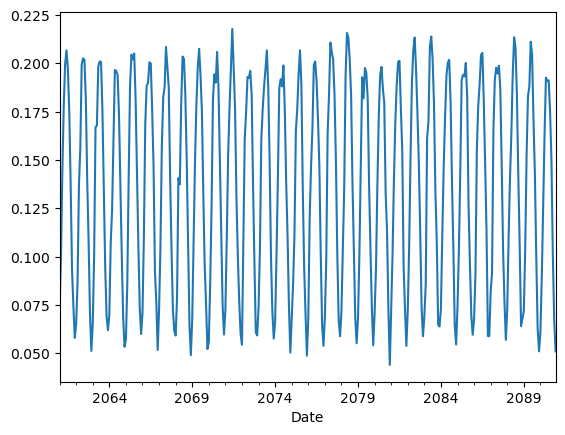

In [14]:
# Quick plot
df_selected.plot()
plt.show()
plt.close()

From the plot above we can have a quick look at the time series, however if we wanted to save this figure for later use, we might want to improve the visualization by adding a few details, such a title, a y-label to indicate the variable and units, a grid for better readibility, a line to indicate the zero line.

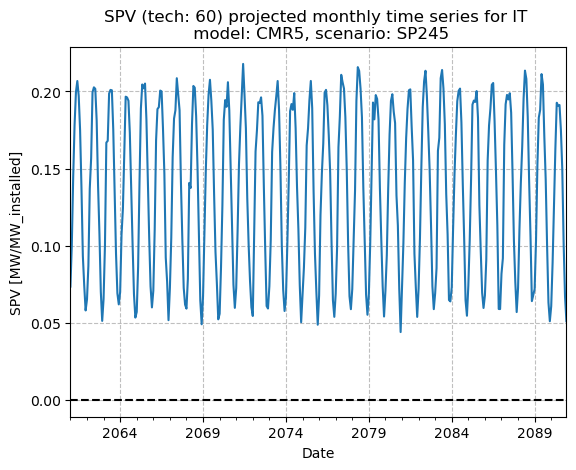

In [15]:
# refined plot
df_selected.plot()
plt.ylabel(f"{var_code} [{units}]")
plt.grid(color="gray", linestyle="--", alpha=0.5)
plt.axhline(y=0.0, color="black", linestyle="dashed", linewidth=1.5)
plt.title(
    f"{var_code} (tech: {technology_str}) projected monthly time series for {country} \n"
    f" model: {model}, scenario: {scenario}"
)
plt.savefig(
    os.path.join(
        results_dir, f"P_{var_code}_{technology_str}_{country}_{model}_{scenario}_monthly_ts.png"
    )
)  # saving the plot
plt.show()
plt.close()

It is now easier to say, for instance, that the future monthly SPV for this specific model and scenario is generally projected to stay between 0.05 and 0.20 (or slightly higher), with no visible trend.

In case we wanted to plot the two stream together, we could do so by adding other DataFrame columns. Let’s plot, for example, both the historical series and the previous projection as yearly averages, so it is easier to compare the two different streams in the same plot.
Let's also try and roughly plot the whole DataFrame at once: this can be useful, especially for sanity check purposes, to see that there are no particular outliers or strange behaviour in the time series.

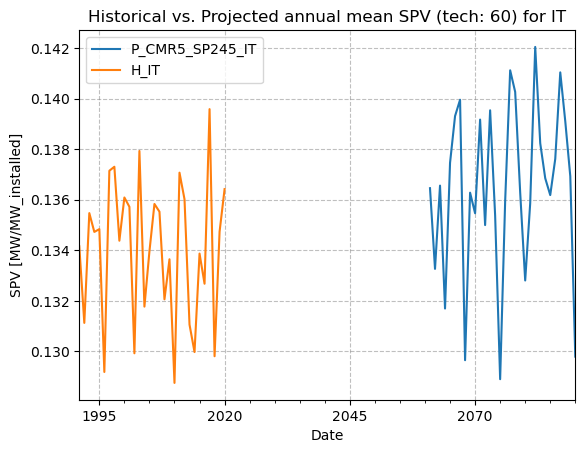

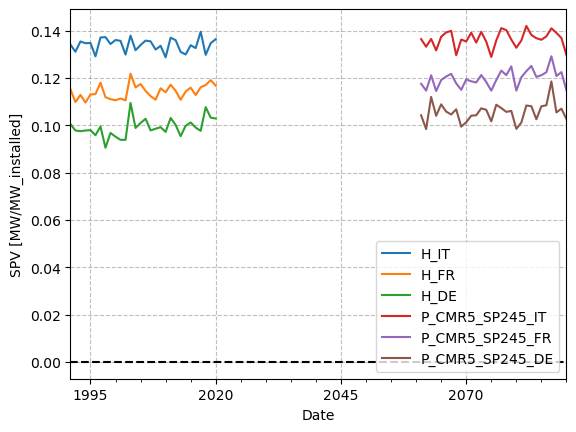

In [20]:
# Plotting 2 columns (hist + proj)
df[[selected_col, f"H_{country}"]].resample("YS").mean().plot()
plt.ylabel(f"{var_code} [{units}]")
plt.grid(color="gray", linestyle="--", alpha=0.5)
plt.title(
    f"Historical vs. Projected annual mean {var_code}" f" (tech: {technology_str}) for {country}"
)
plt.show()
plt.close()

# Plotting whole df
df.resample("YS").mean().plot(legend=False)  # <-- resample and plot the whole df with one line
plt.ylabel(f"{var_code} [{units}]")
plt.legend(loc="lower right")
plt.grid(color="gray", linestyle="--", alpha=0.5)
plt.axhline(y=0.0, color="black", linestyle="dashed", linewidth=1.5)
plt.show()
plt.close()

From the first figure, we can see that the projected SPV annual under this model and scenario looks, on average, slightly higher than the reconstructed one for the years considered. But it would be interesting, and more informative, to study SPV, or any variable, considering all models available for one (or more) scenario.
To go deeper into the analysis of historical and projected data, please have a look at Notebook [*Accessing and visualizing TA data at NUTS 0 aggregation level from the Ensemble of CMIP6 Climate projections*](./climate-change-impacts.ipynb).

### Plot values on a map

To better understand the spatial distribution of the average country-level SPV, we now plot the data on a map rather than presenting it in a purely tabular format. To do so, we can start by choosing one dataset (e.g., the projection data for model CMR5 and scenario SSP245) and calculating the mean of its values over time for each country. Knowing that the dates (time coordinate) information is contained in the index, this can be achieved with one simple line.


In [20]:
# Selecting columns for CMR5 SSP245
model = "CMR5"
scenario = "SP245"
df_p = df.filter(like=f"P_{model}_{scenario}", axis="columns")

# Computing average over time (along index, which contains the dates)
df_mean = df_p.mean(axis=0)

# Converting to DataFrame with variable code as column name
df_mean = pd.DataFrame(df_mean, columns=(var_code,))
print(df_mean)

                      SPV
P_CMR5_SP245_IT  0.136471
P_CMR5_SP245_FR  0.119866
P_CMR5_SP245_DE  0.105550


At this point, we need to load a shape file of the countries of interest: a shapefile is a common geospatial file format used to store vector geographic data, such as points, lines, or polygons (e.g., cities, rivers, or, as in this case, country borders). At the path ```nut0_fpath``` we provide a shape file with the geometries of the countries of interest for the C3S PECD (Pan European Climate Database) domain, including Italy, France, and Germany.

>**Note**    
>This shapefile is available in the project’s GitHub repository. If you run the notebook in other environments (e.g. Colab, Kaggle), make sure to download it (all shapefile sidecar files, not just .shp) and place it at the same relative path to avoid errors.

In [21]:
# Loading and plotting shapefile of countries
shp00 = gp.read_file(nut0_fpath)
print(shp00.head())

  PECD_CODE                                           geometry
0        FR  MULTIPOLYGON (((8.59188 42.37445, 8.76165 42.5...
1        HR  MULTIPOLYGON (((16.59681 46.47590, 16.85476 46...
2        HU  POLYGON ((22.12108 48.37831, 22.15531 48.40340...
3        AL  POLYGON ((19.83100 42.46645, 20.06740 42.55258...
4        AT  POLYGON ((15.75363 48.85218, 16.29009 48.73395...


As we see, the file contains a column with the countries' ISO_CODES (column name is 'PECD_CODE'), and a column with their geometries (borders). All we need to do now is to merge the two sets following the ISO CODES. We will then make sure the ISO CODES are contained in both DataFrames' index and then we will merge.

In [22]:
# setting ISO CODES as the shape file index
shp00 = shp00.set_index("PECD_CODE")
print(shp00.head())

# renaming df_p index leaving just ISO_CODES (to match the shape file index)
df_mean.index = df_mean.index.str[-2:]  # mind: ISO_CODE closes the column name
print(df_mean)

# merging the two keeping only right df's index iso codes (ones of interest)
shp_data = shp00.merge(df_mean, left_index=True, right_index=True, how="right")
print(shp_data)

                                                    geometry
PECD_CODE                                                   
FR         MULTIPOLYGON (((8.59188 42.37445, 8.76165 42.5...
HR         MULTIPOLYGON (((16.59681 46.47590, 16.85476 46...
HU         POLYGON ((22.12108 48.37831, 22.15531 48.40340...
AL         POLYGON ((19.83100 42.46645, 20.06740 42.55258...
AT         POLYGON ((15.75363 48.85218, 16.29009 48.73395...
         SPV
IT  0.136471
FR  0.119866
DE  0.105550
                                             geometry       SPV
IT  MULTIPOLYGON (((12.47792 46.67984, 12.69064 46...  0.136471
FR  MULTIPOLYGON (((8.59188 42.37445, 8.76165 42.5...  0.119866
DE  MULTIPOLYGON (((9.11310 54.87360, 9.29405 54.8...  0.105550


We now have the GeoDataFrame (a table with geospatial information, along with variable values) needed for the map. We can then define a function that plots it and saves the figure to a specified output path.

In [23]:
def plot_regional_map(
    shp_data: gp.GeoDataFrame,
    short_var_name: str,  # abbreviated variable name (e.g., 'SPV')
    var_units: str,  # units of the variable (e.g., 'kW/kW_installed')
    num_levels: int,  # number of discrete color levels in the colorbar
    title: str,  # title of the plot
    outpath: str,  # path where the plot image will be saved
    vmin: int,  # minimum value for the color mapping
    vmax: int,  # maximum value for the color mapping
    cmap: str = "viridis",  # colormap to use for the plot
):
    # Plotting parameters
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ticks for discrete colorbar
    ticks = np.linspace(vmin, vmax, num_levels + 1)
    # cmap for discrete colorbar
    cmap = plt.get_cmap(cmap)
    cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, num_levels)))
    norm = mcolors.BoundaryNorm(ticks, ncolors=num_levels)
    # parameters for colorbar
    rc2 = {"axes.edgecolor": "white", "xtick.color": "white", "xtick.labelcolor": "black"}

    # Plotting data
    shp_data.plot(
        ax=ax,
        column=short_var_name,
        transform=ccrs.PlateCarree(),
        legend=False,  # setting manually discrete colormap
        cmap=cmap,
        norm=norm,  # needed for discrete values
        vmin=vmin,
        vmax=vmax,
        edgecolor="black",
        linewidth=0.2,
    )

    # manually setting discrete colorbar
    cbar_label = f"{short_var_name} [{var_units}]"
    with plt.rc_context(rc2):
        cbar = plt.colorbar(
            ax.collections[0],
            ax=ax,
            orientation="horizontal",
            aspect=30,
            extend="neither",
            pad=0.04,
            shrink=0.55,
            ticks=ticks,
            spacing="uniform",
            label=cbar_label,
            drawedges=True,
        )
        cbar.dividers.set_linewidth(4)

    # Plotting map of countries
    shp_data["geometry"].plot(ax=ax, linewidth=0.5, edgecolor="black", facecolor="none")
    plt.title(title)
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()
    plt.close()

Once the function is defined, we can simply call it defining the needed arguments:

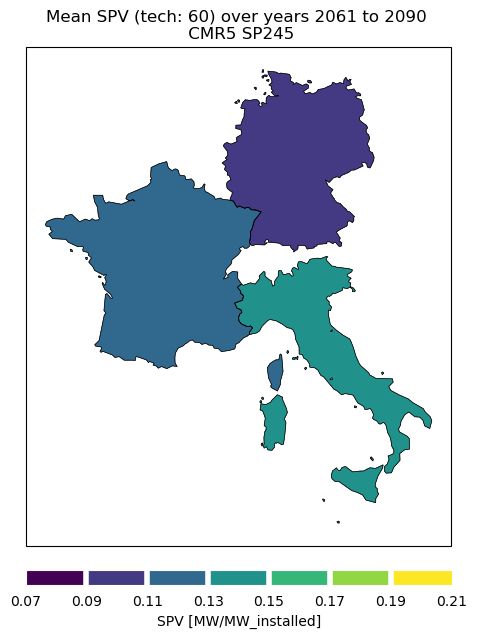

In [24]:
# Defining output path for figure
outpath = os.path.join(
    results_dir, f"mean_proj_{var_code}_{technology_str}_{start_year_p}_{end_year_p}.png"
)
title = (
    f"Mean {var_code} (tech: {technology_str}) over years {start_year_p} to {end_year_p}"
    f" \n {model} {scenario}"
)
# Calling function
plot_regional_map(
    shp_data=shp_data,
    short_var_name=var_code,
    var_units=units,
    num_levels=7,
    title=title,
    outpath=outpath,
    vmin=0.07,
    vmax=0.21,
    cmap="viridis",
)

From this very basic map we see how SPV capacity factor is, of course, generally higher for countries at lower latitudes, following the availability of solar radiation.

## Take home messages 📌

*   Climate data stored in CSV files can be easily read, explored, and summarized using pandas.
*   Mean values over time can be computed and compared across countries using simple operations.
*   Time series for selected countries can be plotted using matplotlib for visual comparison.
*   Resampling to lower temporal resolution can be useful to better visualize and compare the data.
*   Regional mean values can be visualized on a map by joining tabular data with shapefiles.
*   Geopandas and Cartopy enable clean and customizable geographic visualizations.